# Amazon İncelemelerini Kullanarak Öneri Sistemi

## Part 1:

In [67]:
import numpy as np # Lineer cebir
import pandas as pd # Veri işleme
import matplotlib.pyplot
import seaborn as sns

In [68]:
dataSet = pd.read_csv("C:\\Users\\yunusEmre\\Desktop\\amazon\\ratings_Electronics.csv", names = ['userId', 'productId', "rating", 'timestamp'])

In [69]:
dataSet.head() # ekrana gösterir.

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [70]:
dataSet.shape # dizinin boyutunu ve şeklini belirliyoruz

(7824482, 4)

In [71]:
dataSet = dataSet.iloc[:1000000, 0:] # satır ve sütun indisleri kullanarak belirli bir veri aralığını seçiyoruz.

In [72]:
dataSet.dtypes # DataFrame'deki veri tiplerini gösteriyoruz.

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

In [73]:
dataSet.info() # DataFrame'in verilerin özetini istiyoruz. Yani her sütunun ismi, veri tipi, non-null veri sayısı vb...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1000000 non-null  object 
 1   productId  1000000 non-null  object 
 2   rating     1000000 non-null  float64
 3   timestamp  1000000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 30.5+ MB


In [74]:
dataSet.describe()['rating'].T # temel istatistik değerlerini (sayısı, ortalaması ...) gösterir. Sonuçları yatay göstermek 
                               # için transpozunu aldık.

count    1000000.000000
mean           3.973620
std            1.399741
min            1.000000
25%            3.000000
50%            5.000000
75%            5.000000
max            5.000000
Name: rating, dtype: float64

In [75]:
print("Minimum rating is: %d" %(dataSet.rating.min()))
print("Maximum rating is : %d" %(dataSet.rating.max()))

Minimum rating is: 1
Maximum rating is : 5


In [76]:
# Her bir sütundaki eksik değerleri hesaplar. Eğer her hücrede eksik değer varsa kontrol edip True ya da False döndürür.
# Sum fonksiyonu ise her bir sütundaki True değerlerinin sayısını hesaplayıp yazdırır.
print("Number of missing values across columns:\n", dataSet.isnull().sum())

Number of missing values across columns:
 userId       0
productId    0
rating       0
timestamp    0
dtype: int64


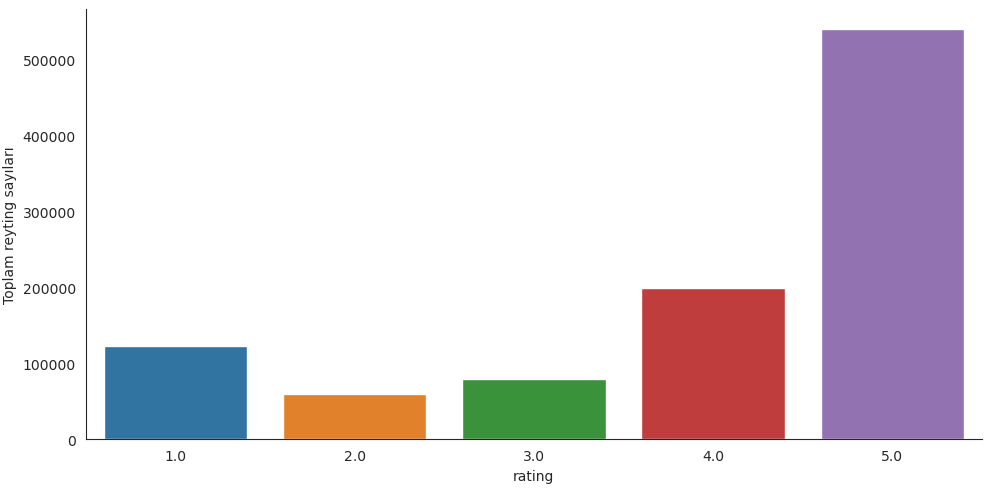

In [77]:
# aspect: çizimin genişlik/ yükseklik oranını ayarlar.
# kind: çizim türünü belirtir. Bu örnekte 'count'
with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=dataSet, aspect=2.0, kind='count')
    g.set_ylabels("Toplam reyting sayıları") # y ekseni